# **Objectives**

This example demonstrates a complete **reentry analysis workflow** using Tudat’s propagation framework. It uses **Kosmos 482** reentry as a test case. Kosmos 482 was an attempted Soviet Venus probe launched on **31 March 1972** that became one of the most significant space-debris reentry cases in recent history. A problem with its rocket stranded the spacecraft in an elliptical orbit around Earth instead of allowing it to continue to Venus. It **reentered Earth’s atmosphere on 10 May 2025**.

Kosmos 482 is exemplary because it allows us to showcase:

- **Long-term orbital decay modeling** over 53 years  
- **Multiple perturbation effects** (atmospheric drag , solar radiation pressure, gravitational perturbations)  
- Retrieving TLE data from <https://www.space-track.org> via Tudatpy’s **SpaceTrack query**  
- **Validation opportunity**, since the actual reentry occurred on **10 May 2025**


# Import Statements
At the beginning of our example, we import all necessary modules.

In [1]:
from datetime import datetime, timedelta
import math
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.collections import LineCollection
import numpy as np
from tudatpy.interface import spice
from tudatpy.dynamics import environment_setup, environment, propagation_setup, propagation, simulator
from tudatpy.astro import time_representation
from tudatpy.util import result2array
from tudatpy.astro.time_representation import DateTime
from tudatpy.data.spacetrack import SpaceTrackQuery
import datetime
from numpy import savetxt

# How to run this script:
 1. With the latest version of Tudat installed, which includes the spacetrack and DISCOS libraries.
 2. With a Space-Track.org account to fetch TLEs directly.

 > **NOTE:**
 > If you don’t have a Space-Track account, you can still run the code by hardcoding
 the TLE directly into the script, as suggested below.

In [14]:
# First, Check if user has SpaceTrack account
# Object ID
objname = "KOSMOS 482 DESCENT CRAFT"
cospar = "1972-023E"
norad_id = str(6073)

answer = input('Do you have a Space-Track.org account? (Y/N): ')
if answer.upper() == 'Y':
    print("Great! You'll be able to download data directly. Please enter you SpaceTrack credentials.")
        
    # Initialize SpaceTrackQuery
    SpaceTrackQuery = SpaceTrackQuery()
    
    # OMM Dict
    json_dict = SpaceTrackQuery.DownloadTle.single_norad_id(SpaceTrackQuery, norad_id)
    
    tle_dict = SpaceTrackQuery.OMMUtils.get_tles(SpaceTrackQuery,json_dict)
    tle_line1, tle_line2 = tle_dict[norad_id][0], tle_dict[norad_id][1]
    tle_reference_epoch = SpaceTrackQuery.OMMUtils.get_tle_reference_epoch(SpaceTrackQuery,tle_line1)
    
    print(f'TLE: \n {tle_line1} \n {tle_line2}')
    print(f'TLE Reference Epoch: \n {tle_reference_epoch}')
    
    #---------------------------------------------------------------------------------------------------------------#
    # TLE (if you do not possess an account to Space-Track.org)
    # tle_line1 = "1  6073U 72023E   25130.02495443  .08088373  12542-4  65849-4 0  9993"  # TLE line 1
    # tle_line2 = "2  6073  51.9455 241.9030 0035390 103.6551  63.6433 16.48653575751319"  # TLE line 2
    #---------------------------------------------------------------------------------------------------------------#
else:
    print("""No worries, we will use the following hardcoded TLEs:
            tle_line1: 1  6073U 72023E   25130.02495443  .08088373  12542-4  65849-4 0  9993
            tle_line2: 2  6073  51.9455 241.9030 0035390 103.6551  63.6433 16.48653575751319""")
    tle_line1 =  "1  6073U 72023E   25130.02495443  .08088373  12542-4  65849-4 0  9993"
    tle_line2 = "2  6073  51.9455 241.9030 0035390 103.6551  63.6433 16.48653575751319"
    tle_reference_epoch = SpaceTrackQuery.OMMUtils.get_tle_reference_epoch(SpaceTrackQuery,tle_line1)

Do you have a Space-Track.org account? (Y/N):  N


No worries, we will use the following hardcoded TLEs:
            tle_line1: 1  6073U 72023E   25130.02495443  .08088373  12542-4  65849-4 0  9993
            tle_line2: 2  6073  51.9455 241.9030 0035390 103.6551  63.6433 16.48653575751319


## Load Spice Kernels
Tudat's default spice kernels are loaded

In [15]:
# Load spice kernels
spice.load_standard_kernels()

## Here, we create a time scale converter object, as we will later need to convert utc times into tdb. 
Tudat's default spice kernels are loaded

## Define Object Info and Initialize SpaceTrackQuery

In the following, we define the object info, the most important of which is the norad_id. This is used to query the spacetrack catalog via Tudatpy's SpaceTrackQuery wrapper function: SpaceTrackQuery.DownloadTle.single_norad_id, in order to automatically retrieve the TLE corresponding to the object based on its norad id. This function returs a dictionary corresponding to the Orbit Mean element Message (OMM) for that given object. This dictionary can them be manipulated to extract, for instance, the TLE and/or other relevant information, such as the TLE reference epoch (time to which the TLE refers to).

> NOTE:
> when initializing SpaceTrackQuery to retrieve TLE, an interactive output will ask you to enter your login credentials to SpaceTrack.org. If you are not registered to the website, you can just use the commented lines below as tle lines. Although all TLEs get updated every few hours, Kosmos 482 has decayed, hence its TLEs will remain the same.

## **Define Object Properties and Simulation Epochs**

We empirically assume a **mass of 480 kg** for `{Kosmos 482}, and a **reference area** (used for both atmospheric drag and solar radiation pressure) of **0.7854 m²**, corresponding to the average projected area of the spacecraft.  
We also specify a **drag coefficient** and a **cut-off altitude** for the simulation, assumed to be **50 km**.

The **simulation start UTC epoch** is defined as the **TLE reference epoch retrieved above**, and the simulation is run for **one year**, although it will automatically terminate whenever the altitude falls below the specified cut-off.

> **NOTES**  
> 1) Tudat’s propagator requires times to be provided as **floating-point Epochs**, hence we apply a conversion using the function: `{from\_python\_datetime}.  
> 2) Since the propagation is performed in **TDB** time scale, we also apply Tudat’s `{default\_time\_scale\_converter} to convert from UTC to TDB.


In [16]:
# object mass
mass = 480 # kg
# DRAG AND SRP AREA, DRAG COEFFICIENT
reference_area_drag = 0.7854 # Average projection area of the spacecraft in m^2
reference_area_radiation = 0.7854  # Average projection area of object for SRP. keep 0.0 to ignore SRP
drag_coefficient = 2.2 # drag coefficient
# CUT-OFF ALTITUDE FOR SIMULATION
altitude_limit = 50.0e3  #meters  (standard 50 km = 50.0e3)
# SET SIMULATION START EPOCH
# THIS EQUALs THE TIME OF THE TLE EPOCH 
simulation_start_utc = tle_reference_epoch
# SET  SIMULATION END EPOCH (cuts off run if altitude criterion not met before)
simulation_end_utc = tle_reference_epoch + timedelta(seconds = 86400*365) # one year after start 

float_observations_start_utc = time_representation.DateTime.from_python_datetime(simulation_start_utc).to_epoch()
float_observations_end_utc = time_representation.DateTime.from_python_datetime(simulation_end_utc).to_epoch()

# Create time scale converter object
time_scale_converter = time_representation.default_time_scale_converter( )

# start and end epoch of simulation conversion from UTC to tdb
simulation_start_epoch_tdb = time_scale_converter.convert_time(
  input_scale = time_representation.utc_scale,
  output_scale = time_representation.tdb_scale,
  input_value = float_observations_start_utc)
simulation_end_epoch_tdb = time_scale_converter.convert_time(
  input_scale = time_representation.utc_scale,
  output_scale = time_representation.tdb_scale,
  input_value = float_observations_end_utc)

## **Output Options**

To give users more control over the level of output detail, we define several **output modes**:

- **`{full}** – selected data, `{J2K} states, and final results  
- **`{selected}** – only the selected data and final results  
- **`{J2K}** – only the propagated `{J2K} states and final results  
- **`{endonly}** – only the final results

Additionally, if you would like to **save states at intermediate intervals**, you can set the flag `{interval\_set} to `'yes'`.


In [17]:
outopt = 'full'

# SET OPTIONAL OUTPUT FILE NAME SUFFIX
filenamesuf = "_KMOS482_480kg_FINAL"

# SET OPTION FOR SAVE INTERVAL IF DESIRED TO NOT SAVE EACH STEP (yes/no?)
interval_set = 'no'
interval = 20  #seconds   10 days = 864000 seconds 1 day = 86400 seconds 1 hr = 3600 seconds

# some values to strings for output later
mass_string = str(mass)
area_string = str(reference_area_drag)
altitude_limit_string = str(altitude_limit)

## **Set Body Settings and Create System of Bodies (as commonly done in Tudatpy)**

We use **Earth** as the **global frame origin**, with the **ECI formulation** being `J2000`.  
All bodies are set to rotate and translate using `get_default_body_settings`, which relies on the previously loaded **SPICE standard kernels**.

To improve accuracy, we overwrite Earth’s default rotation model using `gcrs_to_itrs`, with the **IAU 2006** convention as reference.  
We also choose a more appropriate shape for Earth by modelling it as an **oblate spheroid** with mean radius of $\sim 6378$ km and flattening of $\sim 1/298.25$.

Finally, we add **Kosmos 482** to the system of bodies and define:

- **Constant aerodynamic coefficients** (using the `{nrlmsis00} atmospheric model)
- A **cannonball radiation pressure model**


In [18]:
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon"]
# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)
# Create Earth rotation model
body_settings.get("Earth").rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
                environment_setup.rotation_model.iau_2006,
                global_frame_orientation )
body_settings.get("Earth").gravity_field_settings.associated_reference_frame = "ITRS"
# create atmosphere settings and add to body settings of body "Earth"
body_settings.get( "Earth" ).atmosphere_settings = environment_setup.atmosphere.nrlmsise00()
# Create earth shape model
body_settings.get("Earth").shape_settings = environment_setup.shape.oblate_spherical( 6378137.0, 1.0 / 298.257223563)
# Create empty body settings for Kosmos 482
body_settings.add_empty_settings("kosmos_482")
# Create aerodynamic coefficient interface settings
# reference_area_drag already defined earlier!
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area_drag, [drag_coefficient, 0.0, 0.0]
)
# Add the aerodynamic interface to the body settings
body_settings.get("kosmos_482").aerodynamic_coefficient_settings = aero_coefficient_settings
# Create radiation pressure settings
# reference_area_radiation already defined earlier!
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Earth"]
vehicle_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area_radiation, radiation_pressure_coefficient, occulting_bodies_dict )
# Add the radiation pressure interface to the body settings
body_settings.get("kosmos_482").radiation_pressure_target_settings = vehicle_target_settings
# Add body mass
bodies = environment_setup.create_system_of_bodies(body_settings)
bodies.get("kosmos_482").mass = mass  #mass in kg, already set earlier!

## **Accelerations Acting on Kosmos 482**

In our simulation, **Kosmos 482** is treated as a re-entering object subjected to a number of relevant accelerations:

- **Earth gravity**, modeled as a spherical harmonic expansion up to **degree and order 5**
- **Atmospheric drag**, using the `{nrlmsis00} atmospheric model (as defined earlier)
- **Solar radiation pressure**, modeled with a cannonball approximation
- **Point-mass gravitational attractions** from the **Sun** and the **Moon**

These effects ensure a realistic description of the long-term orbital decay leading to re-entry.


In [19]:
# Define bodies that are propagated
bodies_to_propagate = ["kosmos_482"]
# Define central bodies of propagation
central_bodies = ["Earth"]

# Define accelerations acting on reentry kosmos_482 by Sun and Earth.
accelerations_settings_kosmos_482 = dict(
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        propagation_setup.acceleration.aerodynamic()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ]
)

# Create global accelerations settings dictionary.
acceleration_settings = {"kosmos_482": accelerations_settings_kosmos_482}

# Create the acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

## Starting the Propagation 

Let's retrieve the initial state of the reentry kosmos_482 using Two-Line-Elements as let's set it as initial state for our propagation.

In [20]:
kosmos_482_tle = environment.Tle(
  tle_line1, tle_line2
)
kosmos_482_ephemeris = environment.TleEphemeris( "Earth", "J2000", kosmos_482_tle, False )
initial_state = kosmos_482_ephemeris.cartesian_state(simulation_start_epoch_tdb)

## **Define Dependent Variables to Save**

As is customary in Tudat, we specify the **dependent variables** we wish to save during propagation.  
For re-entry analysis, it is useful to monitor quantities such as:

- **Altitude**
- **Geodetic latitude**
- **Geodetic longitude**
- **Periapsis altitude**
- **Apoapsis altitude**
- **Body-fixed ground speed**


In [21]:
# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.altitude("kosmos_482", "Earth"),
    propagation_setup.dependent_variable.geodetic_latitude("kosmos_482", "Earth"),
    propagation_setup.dependent_variable.longitude("kosmos_482", "Earth"),
    propagation_setup.dependent_variable.periapsis_altitude("kosmos_482", "Earth"),
    propagation_setup.dependent_variable.apoapsis_altitude("kosmos_482", "Earth"),
    propagation_setup.dependent_variable.body_fixed_groundspeed_velocity("kosmos_482", "Earth")
]

## **Ending the Propagation (at Cut-off Altitude)**

Tudat allows the definition of **termination conditions** to stop a simulation once a specified criterion is met.  
In this example, we terminate the propagation as soon as **Kosmos 482’s altitude drops below the prescribed cut-off altitude**.

To ensure robustness, we additionally define a **secondary termination condition** at the **simulation end epoch** — in case, for any reason, the altitude threshold is not reached (even though we expect it to be).


In [22]:
# Define a termination condition to stop once altitude goes below a certain value (defined earlier!)
termination_altitude_settings = propagation_setup.propagator.dependent_variable_termination(
    dependent_variable_settings=propagation_setup.dependent_variable.altitude("kosmos_482", "Earth"),
    limit_value=altitude_limit,
    use_as_lower_limit=True)
# Define a termination condition to stop after a given time (to avoid an endless skipping re-entry)
termination_time_settings = propagation_setup.propagator.time_termination(simulation_end_epoch_tdb)
# Combine the termination settings to stop when one of them is fulfilled
combined_termination_settings = propagation_setup.propagator.hybrid_termination(
    [termination_altitude_settings, termination_time_settings], fulfill_single_condition=True )

## **Define Integrator and Propagation Settings**

At this point, you’re likely familiar with these setup lines from many Tudat examples — here we specify the **integrator settings** (e.g., type and step size) and combine everything into the **propagator settings** object that will run our simulation.


In [23]:
# Create numerical integrator settings
# Create RK settings / RK7(8)
control_settings = propagation_setup.integrator.step_size_control_elementwise_scalar_tolerance( 1.0E-10, 1.0E-10 )
validation_settings = propagation_setup.integrator.step_size_validation( 0.001, 2700.0 )
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step(
    initial_time_step = 60.0,
    coefficient_set = propagation_setup.integrator.rkf_78,
    step_size_control_settings = control_settings,
    step_size_validation_settings = validation_settings )
# Create the propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch_tdb,
    integrator_settings,
    combined_termination_settings,
    output_variables=dependent_variables_to_save
)

# Set output data save interval if defined
if interval_set == 'yes':
    propagator_settings.processing_settings.results_save_frequency_in_seconds = interval
    propagator_settings.processing_settings.results_save_frequency_in_steps = 0

## **Create Dynamics Simulator and Run the Propagation**

We now create the **dynamics simulator object** and perform the propagation.  
After propagation, we extract the results from the simulator’s `state_history` and `dependent_variable_history` attributes.


In [24]:
# Create the simulation objects and propagate the dynamics
dynamics_simulator = simulator.create_dynamics_simulator(
    bodies, propagator_settings
)
# Extract the resulting state history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)
# Extract the resulting simulation dependent variables
dependent_variables = dynamics_simulator.propagation_results.dependent_variable_history
# Convert the dependent variables from a dictionary to a numpy array
dependent_variables_array = result2array(dependent_variables)

## **Write Results to Screen and to Text Files**

We are now ready to **write out and save the results** of our propagation.  

Tudat estimates the **Reentry Window** for Kosmos 482 at approximately:

$$
\textbf{2025-05-10 06:42:00.897397 \; UTC} \quad \pm \quad \mathbf{1.52 \text{ hr}}
$$

at the following geodetic coordinates:

- Latitude: $\mathbf{-43.22^\circ}$
- Longitude: $\mathbf{138.78^\circ}$


In [25]:

data = dependent_variables_array
length = len(data)
lastline= (data[length-1])
print(' ')
print('mass: ' + mass_string + ' kg')
print('drag area: ' + area_string +' m^2')
print('altitude limit: ' + altitude_limit_string  +' meter')
print(' ')
# parse reentry date and position in human-readable format
# time and position
eindtijd = lastline[0]
altid = (lastline[1])/1000.0
lat = math.degrees(lastline[2])
lon = math.degrees(lastline[3])
latstring =  "{:.2f}".format(lat)
lonstring = "{:.2f}".format(lon)
altstring = "{:.3f}".format(altid)
# integration window duration to reentry
duur = eindtijd - simulation_start_epoch_tdb
uren = (duur/3600.0)
urenstring = "{:.3f}".format(uren)
dagen = uren/24.0
dagenstring = "{:.3f}".format(dagen)
# reentry time
date_1 = datetime.datetime(2000,1,1,12,0,0)
eindtijd = eindtijd - 64.184  # tdb to UTC
eindtijd_uren = (eindtijd/3600.0)
eindtijd_dagen = eindtijd_uren/24.0
end_date = date_1 + datetime.timedelta(days=eindtijd_dagen)
reentrydatestring = str(end_date)
propstart = date_1 + datetime.timedelta(days=((float_observations_start_utc/3600.0)/24.0))
propstartstring = str(propstart)
propstartstring = propstartstring + " UTC"
propendstring = str(end_date)
propendstring = propendstring + " UTC"
# get uncertainty estimate (25% of integration window duration)
sigm = 0.25 * uren    # sigma defined as 25% of time between TLE epoch and reentry
if sigm < 26.0:
    formatted_number = "%.2f" % sigm
    sigm_string = str(formatted_number)
    sigm_string = sigm_string + ' hr'
if sigm < 1.0:
    sigm_mins = 0.25 *(duur/60.0)
    formatted_number = "%.2f" % sigm_mins
    sigm_string = str(formatted_number)
    sigm_string = sigm_string + ' min'
if sigm >= 26.0:
    sigm_days = 0.25 * dagen
    formatted_number = "%.2f" % sigm_days
    sigm_string = str(formatted_number)
    sigm_string = sigm_string + ' days'
# print data to screen
print(' ')
print('propagation start:  ' + propstartstring)
print('propagation end:    ' + propendstring)
print(" ")
if (altid * 1e3) > altitude_limit:
    print("OBJECT DID NOT REENTER WITHIN DEFINED TIMESPAN...")
else:
    print('final altitude ' + altstring + ' km')
    print(" ")
    print('reentry after ' + urenstring + ' hours  = ' + dagenstring + ' days')
    print(" ")
    print ('REENTRY AT:')
    print(reentrydatestring + ' UTC  +-  ' + sigm_string)
    print('lat: ' + latstring + '   lon: ' + lonstring)
print(" ")
print(" ")

 
mass: 480 kg
drag area: 0.7854 m^2
altitude limit: 50000.0 meter
 
 
propagation start:  2025-05-10 00:35:56.062752 UTC
propagation end:    2025-05-10 06:42:00.897397 UTC
 
final altitude 49.945 km
 
reentry after 6.100 hours  = 0.254 days
 
REENTRY AT:
2025-05-10 06:42:00.897397 UTC  +-  1.52 hr
lat: -43.22   lon: 138.78
 
 


In [26]:
# Save intermediate data to a comma-delimited txt file if option was chosen earlier
if outopt == 'selected':
    savetxt('variables_out' + filenamesuf + '.txt', dependent_variables_array, delimiter=',')
    savetxt('J2Kstate_out' + filenamesuf + '.txt', states_array, delimiter=',')

In [27]:
if outopt == 'selected':
    savetxt('variables_out' + filenamesuf + '.txt', dependent_variables_array, delimiter=',')

In [28]:
if outopt == 'J2K':
    savetxt('J2Kstate_out' + filenamesuf + '.txt', states_array, delimiter=',')

In [29]:
# Save final data (reentry date and position) to a text file
savetxt('reentrytime_out' + filenamesuf + '.txt', lastline, delimiter=',')

In [30]:
# Re-open the file in append mode and append
file = open('reentrytime_out' + filenamesuf + '.txt', 'a')

In [31]:
#Append reentry info to the file
file.write('\n')
file.write('\n' + 'OBJECT: ' + objname + '\n')
file.write('NORAD ID:  ' + norad_id + '\n')
file.write('COSPAR: ' + cospar + '\n')
file.write('\n')
file.write(tle_line1 + '\n')
file.write(tle_line2 + '\n')
file.write('\n')
file.write('mass: ' + mass_string + ' kg\n')
file.write('drag area: ' + area_string +' m^2\n')
file.write('altitude limit: ' + altitude_limit_string  +' meter\n' + '\n')
file.write('propagation start: ' + propstartstring + '\n')
file.write('propagation end:   ' + propendstring + '\n')
file.write('final altitude:    ' + altstring + '\n')
file.write('\n')
if (altid * 1e3) > altitude_limit:
    file.write('OBJECT DID NOT REENTER IN THIS TIMESPAN\n')
else:
    file.write('reentry after ' + dagenstring + ' days\n')
    file.write('\n')
    file.write('REENTRY AT:\n')
    file.write( reentrydatestring + ' UTC  +-  ' + sigm_string+'\n')
    file.write('lat: ' + latstring + '\n')
    file.write('lon: ' + lonstring + '\n')

# Close the file
file.close()
print("output data have been written to files in home directory")
print(" ")

output data have been written to files in home directory
 


## **Plot Kosmos 482 Ground Track**

Using the **dependent variables** saved during propagation, we can plot the ground track of Kosmos 482.  

To make the visualization more informative and visually appealing, we will use the **Cartopy** and **GeoPandas** libraries.  

Additionally, we will read shapefiles (such as `ne_10m_populated_places.shp`, `ne_10m_populated_places.dbf`, and `ne_10m_populated_places.shx`) — which should be included in your repository — to display cities with populations exceeding one million on the map.  

Fortunately, our predictions indicate that Kosmos 482 will reenter over the ocean.


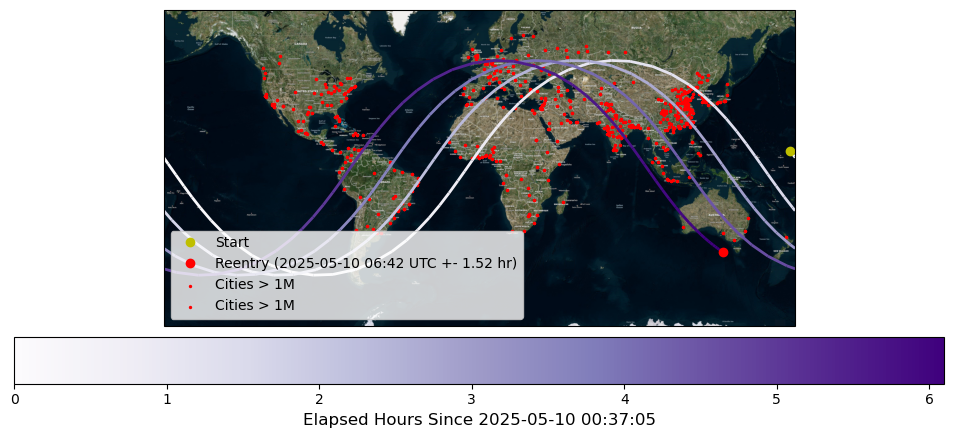

In [32]:
# Load cities data
cities = gpd.read_file("ne_10m_populated_places.shp")
big_cities = cities[cities['POP_MAX'] > 1e6]
# Ground track data
latitudes = np.degrees(dependent_variables_array[:, 2])
longitudes = (np.degrees(dependent_variables_array[:, 3]) + 180) % 360 - 180
times = dependent_variables_array[:, 0]
times_since = (np.array(times) - times[0])/3600
utc_times = [time_representation.DateTime.to_python_datetime(time_representation.DateTime.from_epoch(time)) for time in times]
# Line segments for colored path
points = np.array([longitudes, latitudes]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(times_since.min(), times_since.max())
lc = LineCollection(segments, cmap='Purples', norm=norm, linewidth=2, transform=ccrs.Geodetic())
lc.set_array(times_since)

# Satellite imagery tiler
tiler = cimgt.QuadtreeTiles()  # Good for testing
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=tiler.crs)
#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.add_image(tiler, 4)
# Add colored ground track
ax.add_collection(lc)
cbar = plt.colorbar(lc, ax=ax, orientation='horizontal', pad=0.03)
cbar.set_label(f"Elapsed Hours Since {utc_times[0].strftime('%Y-%m-%d %H:%M:%S')}", fontsize=12)
# Start/End markers
ax.plot(longitudes[0], latitudes[0], 'yo', markersize=6, transform=ccrs.PlateCarree(), label='Start')
ax.plot(longitudes[-1], latitudes[-1], 'ro', markersize=6, transform=ccrs.PlateCarree(), label=f"Reentry ({reentrydatestring[:16]} UTC +- {sigm_string})")
# Add cities > 1M population
ax.scatter(
    big_cities.geometry.x,
    big_cities.geometry.y,
    color='red',
    s=2,
    transform=ccrs.PlateCarree(),
    label='Cities > 1M'
)
# Add cities > 1M population
ax.scatter(
    big_cities.geometry.x,
    big_cities.geometry.y,
    color='red',
    s=2,
    transform=ccrs.PlateCarree(),
    label='Cities > 1M'
)

plt.legend()
plt.show()